In [1]:
import pandas as pd
import numpy as np
import cv2
import keras

Using TensorFlow backend.


In [62]:
df_test.columns

Index(['id', 'filename', 'feature', 'feature_resized'], dtype='object')

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train['feature'] = df_train['filename'].apply(lambda x: cv2.imread(x))
df_test['feature'] = df_test['filename'].apply(lambda x: cv2.imread(x))

In [4]:
df_train['width'] = df_train['feature'].apply(lambda x: x.shape[0])
df_train['lenth'] = df_train['feature'].apply(lambda x: x.shape[1])

In [5]:
dim = ((np.min(df_train['width'].values)+np.max(df_train['width'].values))//2, (np.min(df_train['lenth'].values)+np.max(df_train['lenth'].values))//2)

In [6]:
df_train['feature_resized'] = df_train['feature'].apply(lambda x: cv2.resize(x, dim))
df_test['feature_resized'] = df_test['feature'].apply(lambda x: cv2.resize(x, dim))

In [7]:
x_train = np.array(list(df_train['feature_resized'].values))
x_test = np.array(list(df_test['feature_resized'].values))

In [8]:
y_train = np.array(pd.get_dummies(df_train['label']))

In [9]:
y_train

array([[0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       ...,
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0]], dtype=uint8)

In [10]:
x_train = x_train/255

In [ ]:
x_test = x_test/255

In [79]:
y_train

array([[0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       ...,
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0]], dtype=uint8)

## CNN

In [85]:
df_train['label'].value_counts()

bacterial    350
viral        350
normal       350
covid         77
Name: label, dtype: int64

In [44]:
y_train

array([[0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       ...,
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0]], dtype=uint8)

In [43]:
y_train[1] == 1

array([False, False, False,  True])

In [ ]:
# metric
def mean_pred(y_true, y_pred):
    num_covid = len(y)
    return np.sum(y_pred == y_true)/len(y_true)

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
input_shape = (178, 88, 3)
num_classes = 4
cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(32, (3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(Dense(num_classes, activation='softmax'))

In [51]:
cnn.compile("adam", "categorical_crossentropy", metrics=['accuracy'])
history_cnn = cnn.fit(x_train, y_train,
                      batch_size=128, epochs=32, verbose=1, validation_split=.1)

Train on 1014 samples, validate on 113 samples
Epoch 1/32
1014/1014 [==============================] - 11s 11ms/step - loss: 2.2443 - accuracy: 0.5868 - val_loss: 1.1404 - val_accuracy: 0.5133
Epoch 2/32
1014/1014 [==============================] - 13s 12ms/step - loss: 0.5338 - accuracy: 0.7830 - val_loss: 1.1306 - val_accuracy: 0.6372
Epoch 3/32
1014/1014 [==============================] - 10s 10ms/step - loss: 0.4394 - accuracy: 0.8540 - val_loss: 1.0343 - val_accuracy: 0.6903
Epoch 4/32
1014/1014 [==============================] - 9s 9ms/step - loss: 0.3149 - accuracy: 0.8964 - val_loss: 1.0584 - val_accuracy: 0.6283
Epoch 5/32
1014/1014 [==============================] - 9s 9ms/step - loss: 0.2452 - accuracy: 0.9310 - val_loss: 1.0035 - val_accuracy: 0.6195
Epoch 6/32
1014/1014 [==============================] - 9s 9ms/step - loss: 0.2076 - accuracy: 0.9507 - val_loss: 1.1265 - val_accuracy: 0.6903
Epoch 7/32
1014/1014 [==============================] - 12s 11ms/step - loss: 0.169

In [60]:
import matplotlib.pyplot as plt
def plot_history(logger):
    df = pd.DataFrame(logger.history)
    df[['accuracy', 'val_accuracy']].plot()
    plt.ylabel("accuracy")
    df[['loss', 'val_loss']].plot(linestyle='--', ax=plt.twinx())
    plt.ylabel("loss")

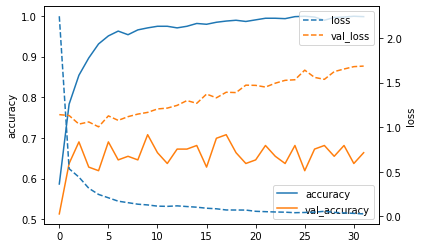

In [61]:
plot_history(history_cnn)

In [65]:
prediction = cnn.predict_classes(x_test)

In [66]:
output = pd.DataFrame({'Id': df_test['id'], 'prediction': prediction})

In [67]:
label_map = {0: 'bacterial', 1: 'covid', 2: 'normal', 3: 'viral'}

In [69]:
output['label'] = output['prediction'].apply(lambda x: label_map[x])

In [71]:
output.drop(columns = 'prediction', inplace = True)

In [76]:
output.to_csv('cnn_prediction.csv', index = False)

## CNN with dropout

In [88]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
input_shape = (178, 88, 3)
num_classes = 4
cnn_dropout = Sequential()
cnn_dropout.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
cnn_dropout.add(MaxPooling2D(pool_size=(2, 2)))
cnn_dropout.add(Dropout(0.5))
cnn_dropout.add(Conv2D(32, (3, 3), activation='relu'))
cnn_dropout.add(MaxPooling2D(pool_size=(2, 2)))
cnn_dropout.add(Flatten())
cnn_dropout.add(Dense(64, activation='relu'))
cnn_dropout.add(Dense(num_classes, activation='softmax'))

In [89]:
cnn_dropout.compile("adam", "categorical_crossentropy", metrics=['accuracy'])
history_cnn_dropout = cnn_dropout.fit(x_train, y_train,
                      batch_size=128, epochs=32, verbose=1, validation_split=.1)

Train on 1014 samples, validate on 113 samples
Epoch 1/32
1014/1014 [==============================] - 11s 11ms/step - loss: 2.1958 - accuracy: 0.3047 - val_loss: 1.3494 - val_accuracy: 0.4779
Epoch 2/32
1014/1014 [==============================] - 13s 13ms/step - loss: 1.3278 - accuracy: 0.3836 - val_loss: 1.3866 - val_accuracy: 0.3097
Epoch 3/32
1014/1014 [==============================] - 13s 13ms/step - loss: 1.3128 - accuracy: 0.3383 - val_loss: 1.3850 - val_accuracy: 0.3097
Epoch 4/32
1014/1014 [==============================] - 13s 13ms/step - loss: 1.2583 - accuracy: 0.3304 - val_loss: 1.3810 - val_accuracy: 0.4071
Epoch 5/32
1014/1014 [==============================] - 14s 14ms/step - loss: 1.1908 - accuracy: 0.5138 - val_loss: 1.3622 - val_accuracy: 0.5310
Epoch 6/32
1014/1014 [==============================] - 13s 13ms/step - loss: 1.0967 - accuracy: 0.5513 - val_loss: 1.3104 - val_accuracy: 0.5133
Epoch 7/32
1014/1014 [==============================] - 15s 15ms/step - loss:

In [93]:
output_dropout = pd.DataFrame({'Id': df_test['id'], 'prediction': cnn_dropout.predict_classes(x_test)})
output_dropout['label'] = output_dropout['prediction'].apply(lambda x: label_map[x])
output_dropout.drop(columns = 'prediction', inplace = True)
output_dropout.to_csv('cnn_dropout_prediction.csv', index = False)

In [ ]:
output_dropout

## Model 2 ResNet

In [86]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, add
from keras.models import Model

num_classes = 10
inputs = Input(shape=input_shape)
conv1_1 = Conv2D(32, kernel_size=(3, 3),
                 activation='relu', padding='same')(inputs)
conv1_2 = Conv2D(32, kernel_size=(3, 3),
                 activation='relu', padding='same')(conv1_1)
conv1_3 = Conv2D(32, kernel_size=(3, 3),
                 activation='relu', padding='same')(conv1_2)
skip1 = add([conv1_1, conv1_3])
conv1_4 = Conv2D(32, kernel_size=(3, 3),
                 activation='relu', padding='same')(skip1)
maxpool1 = MaxPooling2D(pool_size=(2, 2))(conv1_4)
conv2_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(maxpool1)
conv2_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2_1)
skip1 = add([maxpool1, conv2_2])
conv2_3 = Conv2D(32, (3, 3), activation='relu', padding='same')(skip1)
maxpool2 = MaxPooling2D(pool_size=(2, 2))(conv2_3)
flat = Flatten()(maxpool2)
dense = Dense(64, activation='relu')(flat)
predictions = Dense(num_classes, activation='softmax')(dense)

model = Model(inputs=inputs, outputs=predictions)
flat = Flatten()(maxpool2)
dense = Dense(64, activation='relu')(flat)
predictions = Dense(num_classes, activation='softmax')(dense)

model2 = Model(inputs=inputs, outputs=predictions)

In [87]:
model2.compile("adam", "categorical_crossentropy", metrics=['accuracy'])
history_model2 = cnn.fit(x_train, y_train,
                      batch_size=128, epochs=32, verbose=1, validation_split=.1)

Train on 1014 samples, validate on 113 samples
Epoch 1/32
1014/1014 [==============================] - 11s 11ms/step - loss: 0.0246 - accuracy: 1.0000 - val_loss: 1.6976 - val_accuracy: 0.6549
Epoch 2/32
1014/1014 [==============================] - 10s 10ms/step - loss: 0.0232 - accuracy: 1.0000 - val_loss: 1.6812 - val_accuracy: 0.6637
Epoch 3/32
1014/1014 [==============================] - 14s 14ms/step - loss: 0.0228 - accuracy: 0.9990 - val_loss: 1.7131 - val_accuracy: 0.6726
Epoch 4/32
1014/1014 [==============================] - 11s 11ms/step - loss: 0.0210 - accuracy: 1.0000 - val_loss: 1.7375 - val_accuracy: 0.6814
Epoch 5/32
1014/1014 [==============================] - 11s 11ms/step - loss: 0.0193 - accuracy: 0.9990 - val_loss: 1.7645 - val_accuracy: 0.6637
Epoch 6/32
1014/1014 [==============================] - 11s 11ms/step - loss: 0.0190 - accuracy: 1.0000 - val_loss: 1.7660 - val_accuracy: 0.6903
Epoch 7/32
1014/1014 [==============================] - 12s 11ms/step - loss: